In [2]:
# Install a pip package in the current Jupyter kernel
import sys
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install spacy
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m spacy download en_core_web_sm
# !{sys.executable} -m pip install tweet-preprocessor

In [3]:
import spacy
import numpy as np
import pandas as pd
from spacy.lang.en import English
nlp = English()
# Import dataset into Corona
coronaTrain = pd.read_csv('Corona_NLP_train.csv',encoding='latin-1')
# We will use Coronatest later
coronaTest = pd.read_csv('Corona_NLP_test.csv', encoding='latin-1')

<AxesSubplot:>

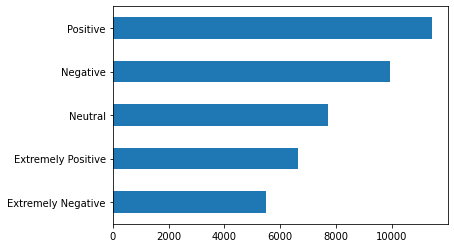

In [4]:
# Plot the counts by sentiment
coronaTrain.Sentiment.value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:>

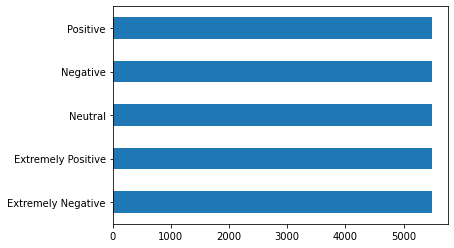

In [5]:
# From the plot below we need to undersample positive, negative, neutral and extremely positive to have
# the same frequency as extremely negative
# First we find out how many are extremely negative
extremelyNegativeSum = coronaTrain['Sentiment'].loc[coronaTrain.Sentiment == 'Extremely Negative'].count()
extremelyNegative = coronaTrain.loc[coronaTrain.Sentiment == 'Extremely Negative']
# Now using that value - we randomly select for each type and create a new dataset
extremelyPositive = coronaTrain[coronaTrain['Sentiment'] == 'Extremely Positive'].sample(extremelyNegativeSum)
neutral = coronaTrain[coronaTrain['Sentiment'] == 'Neutral'].sample(extremelyNegativeSum)
negative = coronaTrain[coronaTrain['Sentiment'] == 'Negative'].sample(extremelyNegativeSum)
positive = coronaTrain[coronaTrain['Sentiment'] == 'Positive'].sample(extremelyNegativeSum)
# Concatenate these datasets together
pdList = [extremelyNegative,extremelyPositive,neutral,negative,positive]
coronaTrainNew = pd.concat(pdList)
# Plot the new dataset
coronaTrainNew.Sentiment.value_counts().sort_values().plot(kind = 'barh')

In [6]:
# The first step we take is to remove stopwords
# We take the list of stopwords from the package spacy
nlp = spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS
coronaTrainNew['tokenizedText'] = coronaTrainNew['OriginalTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))

In [7]:
# Once we have applied stopwords, we look to see if there are any other obvious 
# stopwords that are still common
print(coronaTrainNew['tokenizedText'].str.split(expand=True).stack().value_counts())


#coronavirus               8127
I                          5652
prices                     4112
food                       3561
grocery                    3467
                           ... 
@arielhelwani                 1
#ESPNmma                      1
#ESPN                         1
#UFC                          1
https://t.co/ROjymlPqa4       1
Length: 101732, dtype: int64


In [8]:
# The only obvious one is I
nlp.Defaults.stop_words |= {"I"}
coronaTrainNew['tokenizedText'] = coronaTrainNew['OriginalTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))
print(coronaTrainNew['tokenizedText'].str.split(expand=True).stack().value_counts())

#coronavirus               8127
prices                     4112
food                       3561
grocery                    3467
store                      3439
                           ... 
@arielhelwani                 1
#ESPNmma                      1
#ESPN                         1
#UFC                          1
https://t.co/ROjymlPqa4       1
Length: 101731, dtype: int64


In [9]:
# Next we process the text using the tweet preprocessor package
import preprocessor as p
coronaTrainNew['tokenizedText'] = coronaTrainNew['tokenizedText'].apply(lambda x: p.clean(x))
# Remove punctuation and other various criteria from this
coronaTrainNew['tokenizedText'] = coronaTrainNew['tokenizedText'].str.replace('[^\w\s]','')


C:\Users\patri\AppData\Local\Temp/ipykernel_9004/3958160672.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  coronaTrainNew['tokenizedText'] = coronaTrainNew['tokenizedText'].str.replace('[^\w\s]','')


In [10]:
# Next step is to convert the document into a vector representation.
# Take our Pandas into two separate parts - text and labels
text = coronaTrainNew['tokenizedText'].tolist()
labels = coronaTrainNew['Sentiment'].tolist()
# Next we use scikit learn to vectorize the text
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, use_idf=True)
X = vectorizer.fit(text)
X = vectorizer.transform(text)
print(X)

  (0, 12954)	0.24570287541501487
  (0, 12912)	0.1501407209631852
  (0, 12526)	0.12975100206674317
  (0, 12298)	0.18543375680088617
  (0, 11612)	0.26354177121177325
  (0, 10375)	0.2944748927014253
  (0, 9553)	0.2154075825516975
  (0, 9174)	0.38419420623308853
  (0, 9144)	0.1704013753251655
  (0, 8982)	0.21078210895470206
  (0, 8668)	0.22789501547409438
  (0, 7942)	0.25070667180050094
  (0, 6857)	0.19554829049433092
  (0, 6381)	0.20440267303120394
  (0, 5106)	0.13278069179232674
  (0, 4293)	0.288897873942237
  (0, 3908)	0.19093573234066497
  (0, 2064)	0.33146204026932397
  (1, 14298)	0.15641930725547132
  (1, 11221)	0.2654724710347197
  (1, 9533)	0.22720259140567306
  (1, 8552)	0.1393671944916044
  (1, 8468)	0.24677194120373863
  (1, 7490)	0.19193720799088468
  (1, 7451)	0.17623544193096025
  :	:
  (27403, 3309)	0.2840071437887111
  (27403, 3042)	0.40063536476164685
  (27403, 1832)	0.1854888178638274
  (27403, 601)	0.1408652951629517
  (27404, 14094)	0.1542047538611486
  (27404, 14033)	0

In [11]:
# Applying the Gaussian Naive Bayes method from sklearn
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X.toarray(), labels)

GaussianNB()

In [12]:
# Next we predict the test set text and compare to the actual labels
# First we need to convert the test text in the same way as before (e.g. remove stopwords etc)
coronaTest['text'] = coronaTest['OriginalTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))
coronaTest['text'] = coronaTest['text'].apply(lambda x: p.clean(x))
# Remove punctuation and other various criteria from this
coronaTest['text'] = coronaTest['text'].str.replace('[^\w\s]','')
# Next step is to convert the document into a vector representation.
# Take our Pandas into two separate parts - text and labels
testText = coronaTest['text'].tolist()
testLabels = coronaTest['Sentiment'].tolist()
# Next we use scikit learn to vectorize the text
Xtest = vectorizer.transform(testText)

C:\Users\patri\AppData\Local\Temp/ipykernel_9004/3861609747.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  coronaTest['text'] = coronaTest['text'].str.replace('[^\w\s]','')


In [13]:
# Predict on the processed test text
testPreds = gnb.predict(Xtest.toarray())
# workout accuracy
hit = 0
miss = 0
for i in range(len(testPreds)):
    if testPreds[i] == testLabels[i]:
        hit += 1
    else:
        miss += 1
accuracy = (hit)/(hit+miss)
print(accuracy)

0.2925223802001053


In [20]:
# The second solution we are going to focus on is support vector machines
from sklearn.svm import SVC 
svm = SVC() 
svm.fit(X, labels)

SVC()

In [22]:
testPreds = svm.predict(Xtest)
hit = 0
miss = 0
for i in range(len(testPreds)):
    if testPreds[i] == testLabels[i]:
        hit += 1
    else:
        miss += 1
accuracy = (hit)/(hit+miss)
print(accuracy)

0.5392311743022643
